In [1]:
import os
import re

os.chdir("../..")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.interpolate import griddata

from GaLa_v4 import llaplace

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Taylor Green Vortex

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial x} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial y} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$



where $0 \leq x,y \leq \pi$ and boundary conditions
$$u(x,0) = sin( x)e^{-2 \nu t}, u(x,\pi) = -sin( x)e^{-2 \nu t}$$
$$u(0,y) = u(\pi,y) =0 $$


$$v(0,y) = -sin( y)e^{-2 \nu t}, v(\pi,y) = -sin(y)e^{-2 \nu t}$$
$$v(x,0) = u(x,\pi) =0 $$

This equation has the following analytical solution.

$$u(x,y,t)= sin(x)cos(y)e^{-2 \nu t}$$
$$v(x,y,t)= -cos(x)sin(y)e^{-2 \nu t}$$

In [2]:
def exact_sol(x,y,t,nu):
    u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
    v = -np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
    return u, v

def p_exact_sol(x,y,t,nu,ro = 1):
    return (ro/4)*(np.cos(2*x) + np.sin(2*y))*np.exp(-4*nu*t)

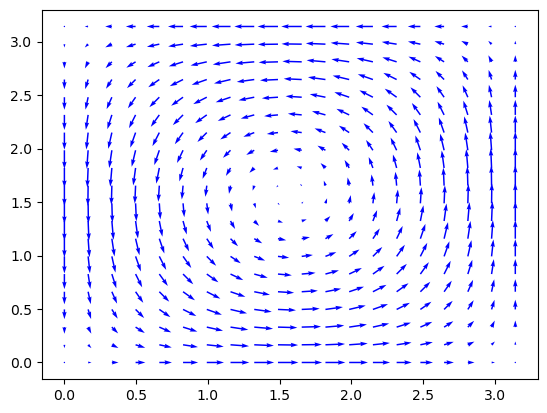

Text(0.5, 0, 'x')

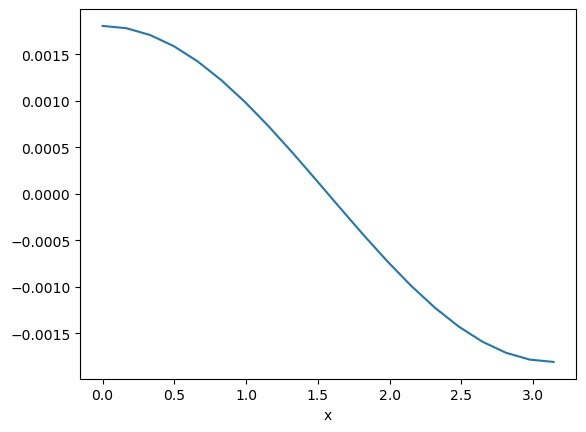

In [3]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,100,100)
nu = 1/16

xx, yy, tt = np.meshgrid(x, y,t)

fig,ax = plt.subplots()

u,v = exact_sol(xx[:,:,0],yy[:,:,0],tt[:,:,50],nu)
img = ax.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")

#     u,v = exact_sol(xx,yy,t[i],nu)

#     img = ax.quiver(x, y, u, v, color='blue') 

#     return img

# ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
# ani.save("TGV_exact.gif", dpi=300, writer=PillowWriter(fps=25))

## Feed Forward Neural Network

In [4]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
# Deep neural network
class Dropout_DNN(torch.nn.Module):
    def __init__(self, layers):
        super(Dropout_DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            layer_list.append(('dropout_%d' % i, torch.nn.Dropout(p = 0.4)))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric Neural PDE

In [6]:
def de(self,data_domain, ro = 1):
    """ The pytorch autograd version of calculating residual """
    f = self(data_domain)
    
    du = torch.autograd.grad(
        f[:,0], data_domain, 
        grad_outputs=torch.ones_like(f[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    dv = torch.autograd.grad(
        f[:,1], data_domain, 
        grad_outputs=torch.ones_like(f[:,1]),
        retain_graph=True,
        create_graph=True
    )[0]

    dp = torch.autograd.grad(
        f[:,2], data_domain, 
        grad_outputs=torch.ones_like(f[:,2]),
        retain_graph=True,
        create_graph=True
    )[0]
    
    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_x = torch.autograd.grad(
        dv[:,0],data_domain, 
        grad_outputs=torch.ones_like(dv[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_y = torch.autograd.grad(
        dv[:,1],data_domain, 
        grad_outputs=torch.ones_like(dv[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    r = du[:,0].reshape(-1,1) + dv[:,1].reshape(-1,1)
    g = du[:,2].reshape(-1,1) + f[:,0].reshape(-1,1) *du[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*du[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,0].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddu_x[:,0].reshape(-1,1) + ddu_y[:,1].reshape(-1,1))
    
    h = dv[:,2].reshape(-1,1) + f[:,0].reshape(-1,1)*dv[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*dv[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,1].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddv_x[:,0].reshape(-1,1) + ddv_y[:,1].reshape(-1,1))
    return torch.cat([r,g,h],axis = 1)

def down_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) - torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def up_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) + torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def left_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) + torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

def right_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) - torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

In [7]:
DNN.de = de
DNN.down_bc = down_bc
DNN.up_bc = up_bc
DNN.left_bc = left_bc
DNN.right_bc = right_bc


Dropout_DNN.de = de
Dropout_DNN.down_bc = down_bc
Dropout_DNN.up_bc = up_bc
Dropout_DNN.left_bc = left_bc
Dropout_DNN.right_bc = right_bc

In [8]:
def samples_space(size = 10,maxl = np.pi):
    xyt = lhs(3, size)
    xyt[:,:2] = xyt[:,:2]*maxl
    xyt[:,-1] = xyt[:,-1]*10
    return xyt

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [9]:
def data_pde(size,minp,maxp):

    xyt, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xyt,param.reshape(-1,1)))).float()
    
    x,y,t = torch.tensor(xyt[:,0]).reshape(-1,1),torch.tensor(xyt[:,1]).reshape(-1,1),torch.tensor(xyt[:,2]).reshape(-1,1)
    param = torch.tensor(param).reshape(-1,1)
    
    down_bc = torch.cat([x,torch.zeros_like(x).float(),t, param],axis = 1).float()

    up_bc = torch.cat([x,torch.ones_like(x).float()*(torch.pi),t, param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(y).float(),y,t, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(y).float()*(torch.pi),y,t, param],axis = 1).float()

    return pde_domain,down_bc,up_bc,left_bc,right_bc

In [10]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

        pde_domain = Variable(pde_domain,requires_grad=True)
        down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred  = pinn.de(pde_domain)
                down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                zeros = torch.zeros_like(pde_pred)

                loss_pde = loss(pde_pred,zeros)
                loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
                loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

                Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
                
                train_loss.append(Loss.item())

                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                 Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                Loss.backward() 

                optimizer.step() 
                
      return train_loss

In [11]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [12]:
# Number of observations
epochs = 5000
#nobs = 1000
nobs = 500
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [4] + 4*[80] + [3]

# model = DNN(layers).to(device)
#dropout_model = Dropout_DNN(layers).to(device)

In [13]:
# loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# loss_history = train_adam(model,loss,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(model.parameters(), 
#     lr=lr, max_iter=50000, max_eval=None, 
#     tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
#     line_search_fn="strong_wolfe" 
#     )

# loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

In [14]:
# loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(dropout_model.parameters(), lr = lr)

# loss_history = train_adam(dropout_model,loss,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(dropout_model.parameters(), 
#     lr=lr, max_iter=50000, max_eval=None, 
#     tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
#     line_search_fn="strong_wolfe" 
#     )

# loss_history_b = train_LBFGS(dropout_model,loss,optimizer, nobs*2,min_param,max_param)

In [15]:
# path = "../Projects-1/Physics _Informed_NN/GaLA/Gala_models/TG_500_obs.pt"
# torch.save(model.state_dict(),path)
#dropout_model.load_state_dict(torch.load(path,  map_location=device))
#dropout_model.eval()

In [16]:
# x = np.linspace(0,1,20)*np.pi
# y = np.linspace(0,1,20)*np.pi
# t = np.linspace(0,2,10)
# nu = 1/100

# xx, yy = np.meshgrid(x, y)

# xx, yy = torch.tensor(xx).reshape(-1,1).float().to(device),torch.tensor(yy).reshape(-1,1).float().to(device)

# X_star = torch.cat([xx,yy,torch.ones_like(xx).to(device)*(t[0]),torch.ones_like(xx).to(device)*(nu)],axis = 1)

# f = model(X_star)

# xx, yy = np.meshgrid(x, y)

# u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,0].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')
# v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,1].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')

# plt.quiver(x, y, u, v, color='blue') 
# plt.show()
# plt.plot(x,u[:,9])
# plt.xlabel("x")

## Ensemble Prediction

In [17]:
x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,10,100)
nu = 1/100

xx, yy,tt = np.meshgrid(x, y, t)

xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

def ensemble(X_star):
    ensemble_predictions = []

    for n in range(10):
        model = DNN(layers).to(device)
        path = f"./Physics _Informed_NN/GaLA/Gala_models/model_{n}_TG.pt"
        model.load_state_dict(torch.load(path,  map_location=device))
        model.eval()
        pred = model(X_star)
        ensemble_predictions.append(pred.detach().numpy())
        
    predictions_ensemble = np.array(ensemble_predictions)
    #mean_pred_ensemble = np.mean(predictions_ensemble, axis=0)  # Mean prediction
    #std_pred_ensemble = np.std(predictions_ensemble, axis=0)  # Standard deviation (uncertainty)

    return np.mean(predictions_ensemble, axis=0),np.std(predictions_ensemble, axis=0)


## MCD Prediciton

In [18]:
dropout_model = Dropout_DNN(layers).to(device)

path = "./Physics _Informed_NN/GaLA/Gala_models/TG_dropout.pt"
dropout_model.load_state_dict(torch.load(path,  map_location=device))
dropout_model.eval()

x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,10,100)
nu = 1/100

xx, yy,tt = np.meshgrid(x, y, t)

xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

def MCD (X_star, samples = 1000):
    dropout_model.train()

    predictions = []

    for _ in range(samples):
        pred = dropout_model(X_star)  # Perform a forward pass with dropout
        predictions.append(pred.cpu().detach().numpy())  # Store the result

    predictions_mcd = np.array(predictions)
    #mean_pred_mcd = np.mean(predictions, axis=0)  # Mean prediction
    #std_pred_mcd = np.std(predictions, axis=0)  # Standard deviation (uncertainty)
    return np.mean(predictions_mcd, axis=0),np.std(predictions_mcd, axis=0)



# DeepGALA Prediction
## Trained with 1,000 observations

0.09999999403953552
0.0999782383441925
0.09992820024490356
0.09983500838279724
0.09967842698097229
0.09943054616451263
0.09905265271663666
0.09849081933498383
0.09766979515552521
0.09648491442203522
0.09479404240846634
0.0924127995967865
0.08912452310323715
0.08472125232219696
0.07909217476844788
0.07233637571334839
0.06481711566448212
0.05707305669784546
0.04962711036205292


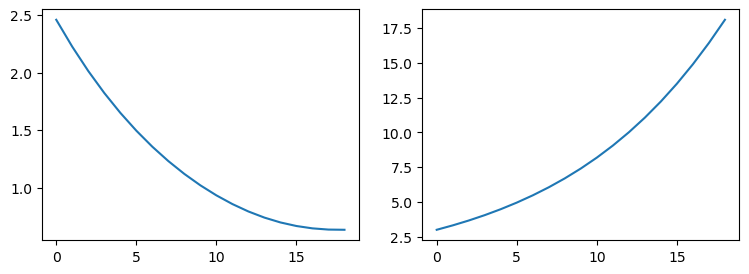

In [19]:
path = "./Physics _Informed_NN/GaLA/Gala_models/Taylor_Green.pt"
model_a = DNN(layers).to(device)
model_a.load_state_dict(torch.load(path,  map_location=device))
model_a.eval()

pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(1000,min_param,max_param)

pde = {"PDE":["de","down_bc","up_bc","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain.to(device),requires_grad=True),
                   "down_bc":down_bc.to(device),
                   "up_bc":up_bc.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp = llaplace(model_a)
llp.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(1, requires_grad=True,device=device), torch.ones(1, requires_grad=True,device=device)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

#llp.sigma_noise = torch.tensor([0.1*np.sqrt(1/12*(1 + 4) )]).float()

error = 1
logprior,logsigma = [],[]

while  error > 5e-2:
    log_prior_x, log_sigma_x = log_prior.cpu().detach().numpy()[0],log_sigma.cpu().detach().numpy()[0]

    hyper_optimizer.zero_grad()
    neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()


    logprior.append(log_prior.cpu().detach().numpy()[0])
    logsigma.append(log_sigma.cpu().detach().numpy()[0])

    error = 0.5*(abs(log_prior.cpu().detach().numpy()[0] - log_prior_x) + abs(log_sigma.cpu().detach().numpy()[0]-log_sigma_x))
    print(error)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(np.exp(logsigma))
axs[1].plot(np.exp(logprior))

# Ensemble Laplace

In [ ]:
# sigma = llp.sigma_noise.clone().cpu().detach().numpy()[0]
# prior = llp.prior_precision.clone().cpu().detach().numpy()[0]
# print(sigma, prior)

In [ ]:
# def laplace_ensemble(pde, sigma, prior):
#     ensemble_laplace = []

#     for n in range(4):
#         model = DNN(layers).to(device)
#         path = f"./Physics _Informed_NN/GaLA/Gala_models/model_{n}_TG.pt"
#         model.load_state_dict(torch.load(path,  map_location=device))
#         model.eval()
#         ll = llaplace(model,sigma_noise= sigma, prior_precision=prior)
#         ll.fit(pde=pde, hessian_structure = "full")

#         ensemble_laplace.append(ll)

#     return np.array(ensemble_laplace)

# def laplace_ensemble_prediction(x,ensemble):
#     mean, std = [],[]
#     for indv in ensemble:
#         f_mu, f_sigma = indv(x)
#         f_mu, f_sigma= f_mu.numpy(), f_sigma.squeeze().sqrt().numpy()

#         mean.append(f_mu)
#         std.append(f_sigma)

#     mean,std = np.array(mean), np.array(std)
#     w = np.repeat(1/ mean.shape[0], mean.shape[0])

#     return np.average(mean, w),np.average(std, w)
    
# ensemble_laplace = laplace_ensemble(pde,sigma, prior)

# DeepGALA Prediction
## Trained with 500 observations

0.10000002384185791
0.09999492764472961
0.09997895359992981
0.09995508193969727
0.10022184252738953
0.09979462623596191
0.099305659532547
0.09870710968971252
0.09793178737163544
0.09688547253608704
0.09546206891536713
0.09351392090320587
0.09089905023574829
0.08743292093276978
0.08301638066768646
0.07755075395107269
0.0712222307920456
0.06436343491077423
0.05740992724895477
0.05074751377105713
0.053727418184280396
0.057251229882240295
0.05952681601047516
0.06052395701408386
0.060238778591156006
0.059341996908187866
0.05657878518104553
0.05274420976638794
0.04750087857246399


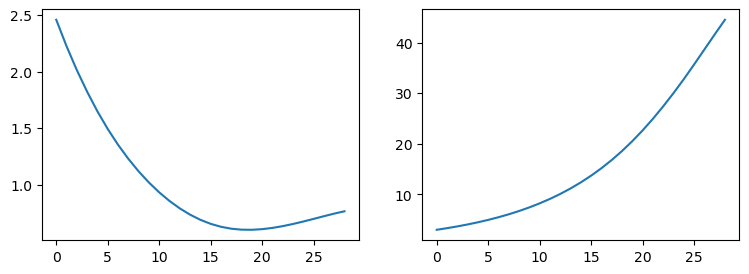

In [20]:
path = "../Projects-1/Physics _Informed_NN/GaLA/Gala_models/TG_500_obs.pt"
model_b = DNN(layers).to(device)
model_b.load_state_dict(torch.load(path,  map_location=device))
model_b.eval()

pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(500,min_param,max_param)

pde = {"PDE":["de","down_bc","up_bc","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain.to(device),requires_grad=True),
                   "down_bc":down_bc.to(device),
                   "up_bc":up_bc.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp_b = llaplace(model_b,sigma_noise=1, prior_precision=1)
llp_b.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(llp.n_params, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

#llp.sigma_noise = torch.tensor([0.1*np.sqrt(1/12*(1 + 4) )]).float()

error = 1
logprior,logsigma = [],[]

while  error > 5e-2:
    log_prior_x, log_sigma_x = log_prior.detach().numpy()[0],log_sigma.detach().numpy()[0]

    hyper_optimizer.zero_grad()
    neg_marglik = - llp_b.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()


    logprior.append(log_prior.detach().numpy()[0])
    logsigma.append(log_sigma.detach().numpy()[0])

    error = 0.5*(abs(log_prior.detach().numpy()[0] - log_prior_x) + abs(log_sigma.detach().numpy()[0]-log_sigma_x))
    print(error)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(np.exp(logsigma))
axs[1].plot(np.exp(logprior))

# Results

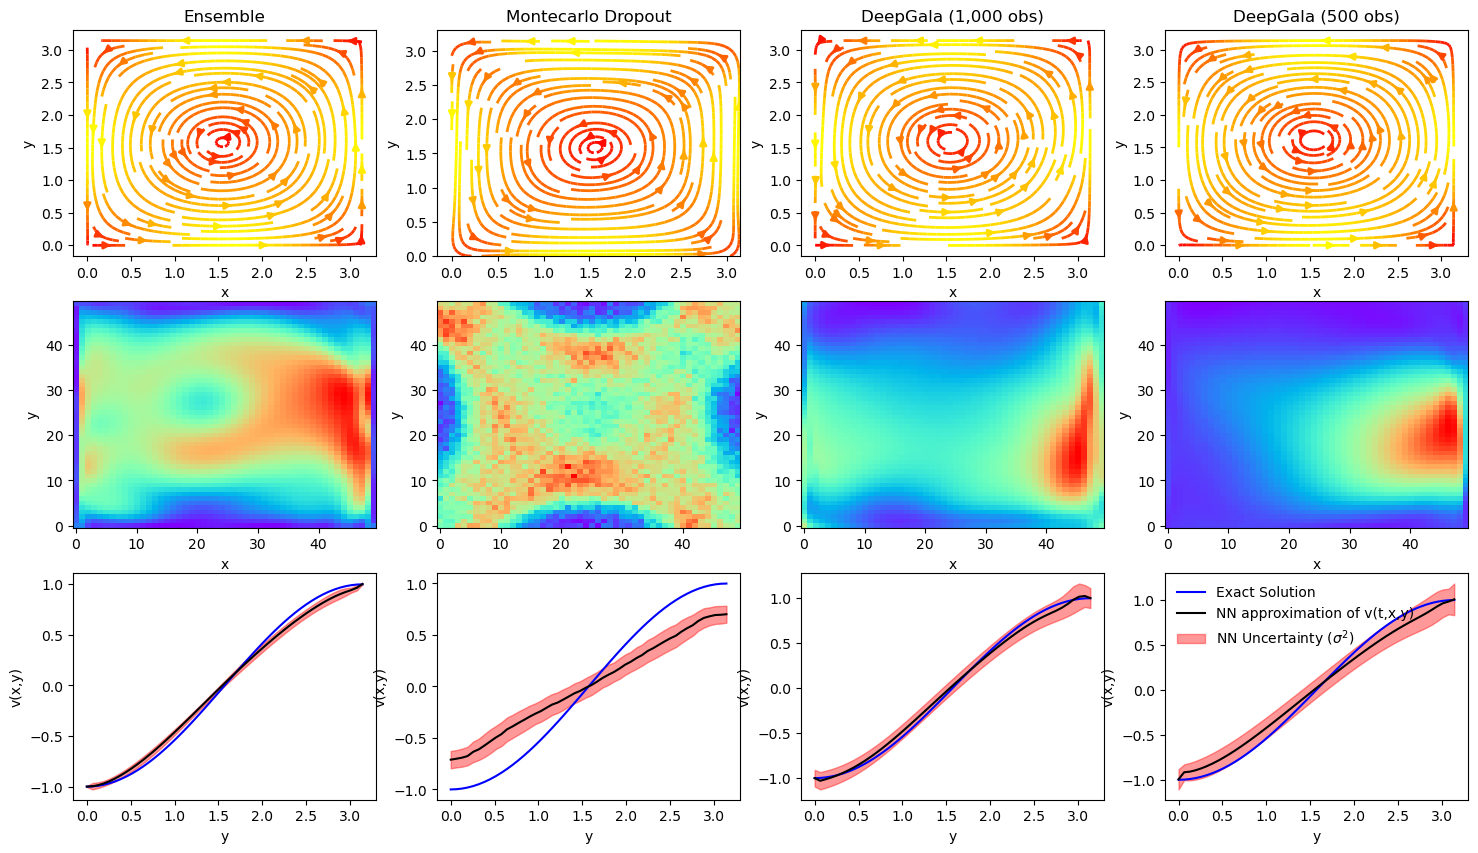

In [21]:
x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,20,100)
nu = 1/100

xx, yy,tt = np.meshgrid(x, y, t)
xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

mean_pred_ensemble, std_pred_ensemble = ensemble(X_star)
mean_pred_mcd,std_pred_mcd =  MCD(X_star)

#llp.sigma_noise = torch.tensor([.50])
f_mu, f_sigma = llp(X_star)
f_mu_b, f_sigma_b = llp_b(X_star)

f_mu, f_sigma= f_mu.numpy(), f_sigma.squeeze().sqrt().numpy()
f_mu_b, f_sigma_b= f_mu_b.numpy(), f_sigma_b.squeeze().sqrt().numpy()

# f_mu_ensemble, f_sigma_ensemble = laplace_ensemble_prediction(X_star,ensemble_laplace)

u,v = exact_sol(xx,yy,tt,nu)
p = p_exact_sol(xx,yy,tt,nu)

xx, yy = np.meshgrid(x, y)

## Exact Solution
u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

## Ensemble 
u_pred_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,0], (xx,yy), method='cubic')
u_pred_var_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,0], (xx,yy), method='cubic')
v_pred_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,1], (xx,yy), method='cubic')
v_pred_var_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,1], (xx,yy), method='cubic')
p_pred_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,2], (xx,yy), method='cubic')
p_pred_var_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,2], (xx,yy), method='cubic')

## MCD
u_pred_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,0], (xx,yy), method='cubic')
u_pred_var_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,0], (xx,yy), method='cubic')
v_pred_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,1], (xx,yy), method='cubic')
v_pred_var_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,1], (xx,yy), method='cubic')
p_pred_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,2], (xx,yy), method='cubic')
p_pred_var_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,2], (xx,yy), method='cubic')

## DeepGala 1000
u_pred_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
u_pred_var_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
v_pred_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
v_pred_var_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
p_pred_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
p_pred_var_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')

## DeepGala 500
u_pred_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_b[:,0], (xx,yy), method='cubic')
u_pred_var_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_b[:,0], (xx,yy), method='cubic')
v_pred_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_b[:,1], (xx,yy), method='cubic')
v_pred_var_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_b[:,1], (xx,yy), method='cubic')
p_pred_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_b[:,2], (xx,yy), method='cubic')
p_pred_var_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_b[:,2], (xx,yy), method='cubic')

## Ensemble DeepGala
# u_pred_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_ensemble[:,0], (xx,yy), method='cubic')
# u_pred_var_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_ensemble[:,0], (xx,yy), method='cubic')
# v_pred_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_ensemble[:,1], (xx,yy), method='cubic')
# v_pred_var_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_ensemble[:,1], (xx,yy), method='cubic')
# p_pred_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_ensemble[:,2], (xx,yy), method='cubic')
# p_pred_var_dge = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_ensemble[:,2], (xx,yy), method='cubic')

fig, axs = plt.subplots(3, 4, figsize=(18, 10))

## Ensemble
speed = np.sqrt(u_pred_ensemble**2 + v_pred_ensemble**2)
lw = speed
strm = axs[0,0].streamplot(x, y, u_pred_ensemble, v_pred_ensemble, color=lw, linewidth=2, cmap='autumn')
#fig.colorbar(strm.lines)
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].set_title("Ensemble")

speed = np.sqrt(u_pred_var_ensemble**2 + v_pred_var_ensemble**2)
lw = speed 
strm = axs[1,0].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#fig.colorbar(strm)
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")

axs[2,0].plot(x,v[25,:], color = "blue", label = "Exact Solution")
axs[2,0].plot(x,v_pred_ensemble[25,:], color = "black", label = "NN approximation of v(t,x,y)")
axs[2,0].fill_between(x.reshape(-1), v_pred_ensemble[25,:]+v_pred_var_ensemble[25,:],v_pred_ensemble[25,:]-v_pred_var_ensemble[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
axs[2,0].set_ylabel("v(x,y)")
axs[2,0].set_xlabel("y")

## MCD
speed = np.sqrt(u_pred_mcd**2 + v_pred_mcd**2)
lw = speed 
strm = axs[0,1].streamplot(x, y, u_pred_mcd, v_pred_mcd, color=lw, linewidth=2, cmap='autumn')
#fig.colorbar(strm.lines)
axs[0,1].set_xlabel("x")
axs[0,1].set_ylabel("y")
axs[0,1].set_title("Montecarlo Dropout")

speed = np.sqrt(u_pred_var_mcd**2 + v_pred_var_mcd**2)
lw = speed 
strm = axs[1,1].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#fig.colorbar(strm)
axs[1,1].set_xlabel("x")
axs[1,1].set_ylabel("y")

axs[2,1].plot(x,v[25,:], color = "blue", label = "Exact Solution")
axs[2,1].plot(x,v_pred_mcd[25,:], color = "black", label = "NN approximation of v(t,x,y)")
axs[2,1].fill_between(x.reshape(-1), v_pred_mcd[25,:]+v_pred_var_mcd[25,:],v_pred_mcd[25,:]-v_pred_var_mcd[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
axs[2,1].set_ylabel("v(x,y)")
axs[2,1].set_xlabel("y")

## DeepGala
speed = np.sqrt(u_pred_dg**2 + v_pred_dg**2)
lw = speed 
strm = axs[0,2].streamplot(x, y, u_pred_dg, v_pred_dg, color=lw, linewidth=2, cmap='autumn')
#fig.colorbar(strm.lines)
axs[0,2].set_xlabel("x")
axs[0,2].set_ylabel("y")
axs[0,2].set_title("DeepGala (1,000 obs)")

speed = np.sqrt(u_pred_var_dg**2 + v_pred_var_dg**2)
lw = speed 
strm = axs[1,2].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#fig.colorbar(strm)
axs[1,2].set_xlabel("x")
axs[1,2].set_ylabel("y")


axs[2,2].plot(x,v[25,:], color = "blue", label = "Exact Solution")
axs[2,2].plot(x,v_pred_dg[25,:], color = "black", label = "NN approximation of v(t,x,y)")
axs[2,2].fill_between(x.reshape(-1), v_pred_dg[25,:]+v_pred_var_dg[25,:],v_pred_dg[25,:]-v_pred_var_dg[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
axs[2,2].set_ylabel("v(x,y)")
axs[2,2].set_xlabel("y")

## DeepGala b
speed = np.sqrt(u_pred_dgb**2 + v_pred_dgb**2)
lw = speed 
strm = axs[0,3].streamplot(x, y, u_pred_dgb, v_pred_dgb, color=lw, linewidth=2, cmap='autumn')
#fig.colorbar(strm.lines)
axs[0,3].set_xlabel("x")
axs[0,3].set_ylabel("y")
axs[0,3].set_title("DeepGala (500 obs)")

speed = np.sqrt(u_pred_var_dgb**2 + v_pred_var_dgb**2)
lw = speed 
strm = axs[1,3].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#fig.colorbar(strm)
axs[1,3].set_xlabel("x")
axs[1,3].set_ylabel("y")

axs[2,3].plot(x,v[25,:], color = "blue", label = "Exact Solution")
axs[2,3].plot(x,v_pred_dgb[25,:], color = "black", label = "NN approximation of v(t,x,y)")
axs[2,3].fill_between(x.reshape(-1), v_pred_dgb[25,:]+v_pred_var_dgb[25,:],v_pred_dgb[25,:]-v_pred_var_dgb[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
axs[2,3].set_ylabel("v(x,y)")
axs[2,3].set_xlabel("y")

axs[2,3].legend(frameon =False)


## Ensemble DeepGala 
# speed = np.sqrt(u_pred_dgb**2 + v_pred_dgb**2)
# lw = speed 
# strm = axs[0,3].streamplot(x, y, u_pred_dgb, v_pred_dgb, color=lw, linewidth=2, cmap='autumn')
# #fig.colorbar(strm.lines)
# axs[0,3].set_xlabel("x")
# axs[0,3].set_ylabel("y")
# axs[0,3].set_title("DeepGala (500 obs)")

# speed = np.sqrt(u_pred_var_dgb**2 + v_pred_var_dgb**2)
# lw = speed 
# strm = axs[1,3].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# #fig.colorbar(strm)
# axs[1,3].set_xlabel("x")
# axs[1,3].set_ylabel("y")

# axs[2,3].plot(x,v[25,:], color = "blue", label = "Exact Solution")
# axs[2,3].plot(x,v_pred_dgb[25,:], color = "black", label = "NN approximation of v(t,x,y)")
# axs[2,3].fill_between(x.reshape(-1), v_pred_dgb[25,:]+v_pred_var_dgb[25,:],v_pred_dgb[25,:]-v_pred_var_dgb[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
# axs[2,3].set_ylabel("v(x,y)")
# axs[2,3].set_xlabel("y")

# axs[2,3].legend(frameon =False)

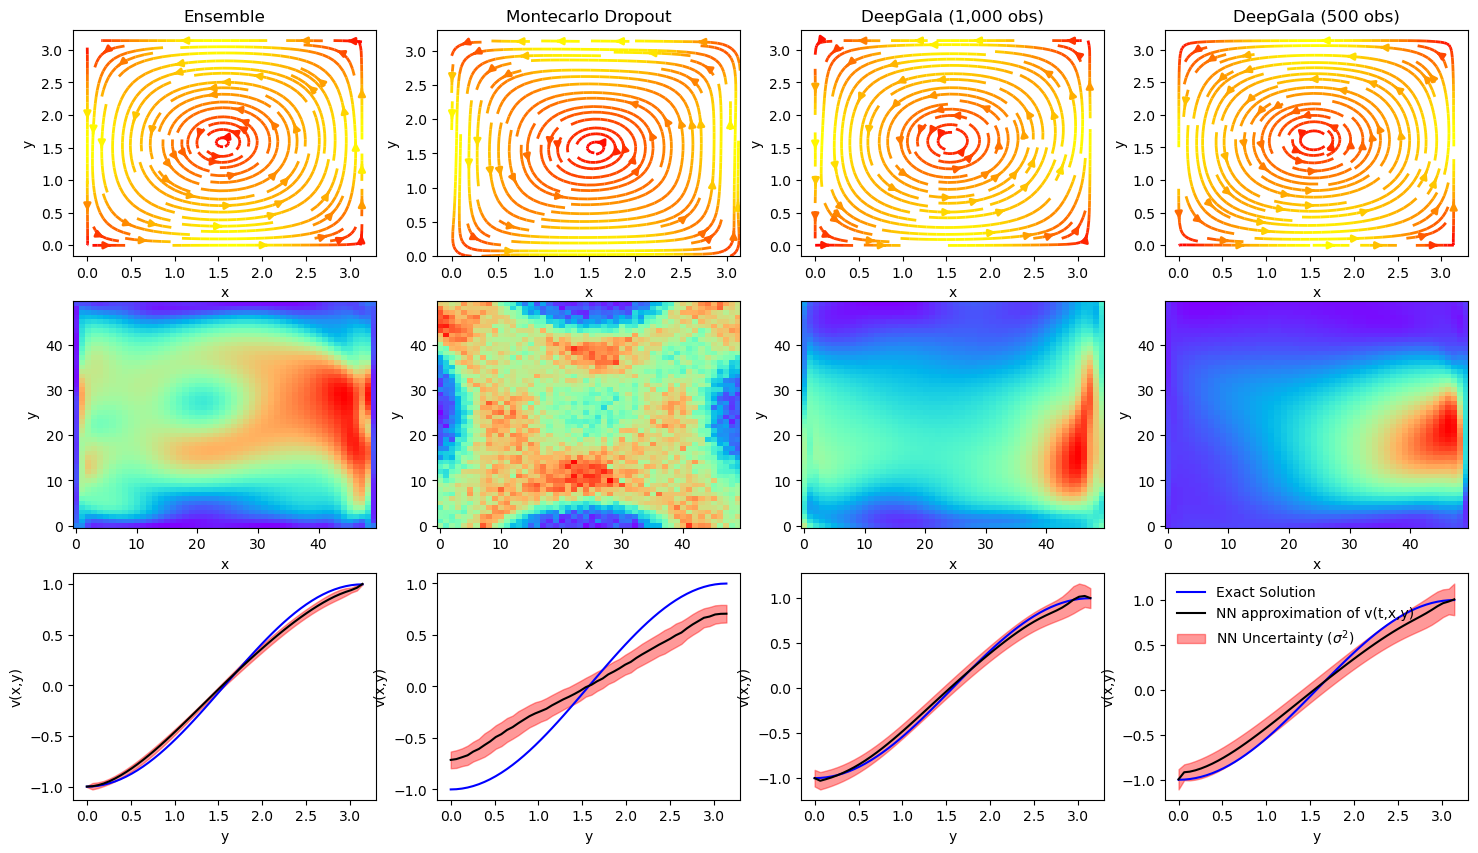

In [22]:
from matplotlib.animation import FuncAnimation, PillowWriter

x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,15,100)
nu = 1/100

fig, axs = plt.subplots(3, 4, figsize=(18, 10))

def animate(i):

    xx, yy,tt = np.meshgrid(x, y, t)
    xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,i]).reshape(-1,1).float().to(device)

    X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

    mean_pred_ensemble, std_pred_ensemble = ensemble(X_star)
    mean_pred_mcd,std_pred_mcd =  MCD(X_star)

    #llp.sigma_noise = torch.tensor([.50])
    f_mu, f_sigma = llp(X_star)
    f_mu_b, f_sigma_b = llp_b(X_star)

    f_mu, f_sigma= f_mu.numpy(), f_sigma.squeeze().sqrt().numpy()
    f_mu_b, f_sigma_b= f_mu_b.numpy(), f_sigma_b.squeeze().sqrt().numpy()

    # f_mu_ensemble, f_sigma_ensemble = laplace_ensemble_prediction(X_star,ensemble_laplace)

    u,v = exact_sol(xx,yy,tt,nu)

    xx, yy = np.meshgrid(x, y)

    ## Exact Solution
    u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
    v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')

    ## Ensemble 
    u_pred_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,0], (xx,yy), method='cubic')
    u_pred_var_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,0], (xx,yy), method='cubic')
    v_pred_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,1], (xx,yy), method='cubic')
    v_pred_var_ensemble = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,1], (xx,yy), method='cubic')

    ## MCD
    u_pred_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,0], (xx,yy), method='cubic')
    u_pred_var_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,0], (xx,yy), method='cubic')
    v_pred_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,1], (xx,yy), method='cubic')
    v_pred_var_mcd = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,1], (xx,yy), method='cubic')

    ## DeepGala 1000
    u_pred_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
    u_pred_var_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
    v_pred_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
    v_pred_var_dg = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')

    ## DeepGala 500
    u_pred_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_b[:,0], (xx,yy), method='cubic')
    u_pred_var_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_b[:,0], (xx,yy), method='cubic')
    v_pred_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu_b[:,1], (xx,yy), method='cubic')
    v_pred_var_dgb = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma_b[:,1], (xx,yy), method='cubic')

    axs[0,0].clear()
    axs[0,1].clear()
    axs[0,2].clear()
    axs[0,3].clear()
    axs[1,0].clear()
    axs[1,1].clear()
    axs[1,2].clear()
    axs[1,3].clear()
    axs[2,0].clear()
    axs[2,1].clear()
    axs[2,2].clear()
    axs[2,3].clear()


    ## Ensemble
    speed = np.sqrt(u_pred_ensemble**2 + v_pred_ensemble**2)
    lw = speed
    im1 = axs[0,0].streamplot(x, y, u_pred_ensemble, v_pred_ensemble, color=lw, linewidth=2, cmap='autumn')
    #fig.colorbar(strm.lines)
    axs[0,0].set_xlabel("x")
    axs[0,0].set_ylabel("y")
    axs[0,0].set_title("Ensemble")

    speed = np.sqrt(u_pred_var_ensemble**2 + v_pred_var_ensemble**2)
    lw = speed 
    im2 = axs[1,0].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
    #fig.colorbar(strm)
    axs[1,0].set_xlabel("x")
    axs[1,0].set_ylabel("y")

    im3 = axs[2,0].plot(x,v[25,:], color = "blue", label = "Exact Solution")
    im4 = axs[2,0].plot(x,v_pred_ensemble[25,:], color = "black", label = "NN approximation of v(t,x,y)")
    im5 = axs[2,0].fill_between(x.reshape(-1), v_pred_ensemble[25,:]+v_pred_var_ensemble[25,:],v_pred_ensemble[25,:]-v_pred_var_ensemble[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[2,0].set_ylabel("v(x,y)")
    axs[2,0].set_xlabel("y")

    ## MCD
    speed = np.sqrt(u_pred_mcd**2 + v_pred_mcd**2)
    lw = speed 
    im6 = axs[0,1].streamplot(x, y, u_pred_mcd, v_pred_mcd, color=lw, linewidth=2, cmap='autumn')
    #fig.colorbar(strm.lines)
    axs[0,1].set_xlabel("x")
    axs[0,1].set_ylabel("y")
    axs[0,1].set_title("Montecarlo Dropout")

    speed = np.sqrt(u_pred_var_mcd**2 + v_pred_var_mcd**2)
    lw = speed 
    im7 = axs[1,1].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
    #fig.colorbar(strm)
    axs[1,1].set_xlabel("x")
    axs[1,1].set_ylabel("y")

    im8 = axs[2,1].plot(x,v[25,:], color = "blue", label = "Exact Solution")
    im9 = axs[2,1].plot(x,v_pred_mcd[25,:], color = "black", label = "NN approximation of v(t,x,y)")
    im10 = axs[2,1].fill_between(x.reshape(-1), v_pred_mcd[25,:]+v_pred_var_mcd[25,:],v_pred_mcd[25,:]-v_pred_var_mcd[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[2,1].set_ylabel("v(x,y)")
    axs[2,1].set_xlabel("y")

    ## DeepGala
    speed = np.sqrt(u_pred_dg**2 + v_pred_dg**2)
    lw = speed 
    im11 = axs[0,2].streamplot(x, y, u_pred_dg, v_pred_dg, color=lw, linewidth=2, cmap='autumn')
    #fig.colorbar(strm.lines)
    axs[0,2].set_xlabel("x")
    axs[0,2].set_ylabel("y")
    axs[0,2].set_title("DeepGala (1,000 obs)")

    speed = np.sqrt(u_pred_var_dg**2 + v_pred_var_dg**2)
    lw = speed 
    im12 = axs[1,2].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
    #fig.colorbar(strm)
    axs[1,2].set_xlabel("x")
    axs[1,2].set_ylabel("y")


    im13 = axs[2,2].plot(x,v[25,:], color = "blue", label = "Exact Solution")
    im14 = axs[2,2].plot(x,v_pred_dg[25,:], color = "black", label = "NN approximation of v(t,x,y)")
    im15 = axs[2,2].fill_between(x.reshape(-1), v_pred_dg[25,:]+v_pred_var_dg[25,:],v_pred_dg[25,:]-v_pred_var_dg[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[2,2].set_ylabel("v(x,y)")
    axs[2,2].set_xlabel("y")

    ## DeepGala b
    speed = np.sqrt(u_pred_dgb**2 + v_pred_dgb**2)
    lw = speed 
    im16 = axs[0,3].streamplot(x, y, u_pred_dgb, v_pred_dgb, color=lw, linewidth=2, cmap='autumn')
    #fig.colorbar(strm.lines)
    axs[0,3].set_xlabel("x")
    axs[0,3].set_ylabel("y")
    axs[0,3].set_title("DeepGala (500 obs)")

    speed = np.sqrt(u_pred_var_dgb**2 + v_pred_var_dgb**2)
    lw = speed 
    im17 = axs[1,3].imshow(lw, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
    #fig.colorbar(strm)
    axs[1,3].set_xlabel("x")
    axs[1,3].set_ylabel("y")

    im18 = axs[2,3].plot(x,v[25,:], color = "blue", label = "Exact Solution")
    im19 = axs[2,3].plot(x,v_pred_dgb[25,:], color = "black", label = "NN approximation of v(t,x,y)")
    im20 = axs[2,3].fill_between(x.reshape(-1), v_pred_dgb[25,:]+v_pred_var_dgb[25,:],v_pred_dgb[25,:]-v_pred_var_dgb[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[2,3].set_ylabel("v(x,y)")
    axs[2,3].set_xlabel("y")

    axs[2,3].legend(frameon =False)
    return im1,im2,im3,im4,im5,im6, im7, im8, im9, im10, im11, im12, im13, im14, im15, im16, im17, im18, im19, im20 

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=50)    
ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
# x = np.linspace(0,1,50)*np.pi
# y = np.linspace(0,1,50)*np.pi
# t = np.linspace(0,10,100)
# nu = 1/100

# xx, yy,tt = np.meshgrid(x, y, t)
# xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)


# u,v = exact_sol(xx,yy,tt,nu)
# p = p_exact_sol(xx,yy,tt,nu)

# xx, yy = np.meshgrid(x, y)

# u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
# v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
# p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

# u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,0], (xx,yy), method='cubic')
# u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,0], (xx,yy), method='cubic')
# v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,1], (xx,yy), method='cubic')
# v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,1], (xx,yy), method='cubic')
# p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_ensemble[:,2], (xx,yy), method='cubic')
# p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_ensemble[:,2], (xx,yy), method='cubic')


# fig,ax = plt.subplots(3,4,figsize=(18,10))
       
# ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[0,0].set_title("u(x,y,t) exact Solution")
# uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[0,1].set_title("u(x,y,t) NN Approximation")
# h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[0,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[0,3].plot(x,u[:,25])
# ax[0,3].plot(x,u_pred[:,25])
# ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[1,0].set_title("v(x,y,t) exact Solution")
# uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[1,1].set_title("v(x,y,t) NN Approximation")
# h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[1,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[1,3].plot(x,v[25,:])
# ax[1,3].plot(x,v_pred[25,:])
# ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[2,0].set_title("p(x,y,t) exact Solution")
# uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[2,1].set_title("p(x,y,t) NN Approximation")
# h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[2,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[2,3].plot(x,p[25,:])
# ax[2,3].plot(x,p_pred[25,:])
# ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


In [ ]:
# x = np.linspace(0,1,50)*np.pi
# y = np.linspace(0,1,50)*np.pi
# t = np.linspace(0,10,100)
# nu = 1/100

# xx, yy,tt = np.meshgrid(x, y, t)
# xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

# u,v = exact_sol(xx,yy,tt,nu)
# p = p_exact_sol(xx,yy,tt,nu)

# xx, yy = np.meshgrid(x, y)

# u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
# v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
# p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

# u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,0], (xx,yy), method='cubic')
# u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,0], (xx,yy), method='cubic')
# v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,1], (xx,yy), method='cubic')
# v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,1], (xx,yy), method='cubic')
# p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred_mcd[:,2], (xx,yy), method='cubic')
# p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred_mcd[:,2], (xx,yy), method='cubic')


# fig,ax = plt.subplots(3,4,figsize=(18,10))
       
# ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[0,0].set_title("u(x,y,t) exact Solution")
# uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[0,1].set_title("u(x,y,t) NN Approximation")
# h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[0,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[0,3].plot(x,u[:,25])
# ax[0,3].plot(x,u_pred[:,25])
# ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[1,0].set_title("v(x,y,t) exact Solution")
# uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[1,1].set_title("v(x,y,t) NN Approximation")
# h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[1,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[1,3].plot(x,v[25,:])
# ax[1,3].plot(x,v_pred[25,:])
# ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[2,0].set_title("p(x,y,t) exact Solution")
# uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[2,1].set_title("p(x,y,t) NN Approximation")
# h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[2,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[2,3].plot(x,p[25,:])
# ax[2,3].plot(x,p_pred[25,:])
# ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


In [ ]:
# x = np.linspace(0,1,50)*np.pi
# y = np.linspace(0,1,50)*np.pi
# t = np.linspace(0,10,100)
# nu = 1/100

# xx, yy,tt = np.meshgrid(x, y, t)
# xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)


# x = np.linspace(0,1,50)*np.pi
# y = np.linspace(0,1,50)*np.pi
# t = np.linspace(0,10,100)
# nu = 1/100

# xx, yy,tt = np.meshgrid(x, y, t)

# xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

# X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

# f_mu, f_sigma = llp(X_star)

# f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()

# u,v = exact_sol(xx,yy,tt,nu)
# p = p_exact_sol(xx,yy,tt,nu)

# xx, yy = np.meshgrid(x, y)

# u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
# v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
# p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

# u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
# u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
# v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
# v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
# p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
# p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')


# fig,ax = plt.subplots(3,4,figsize=(18,10))
       
# ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[0,0].set_title("u(x,y,t) exact Solution")
# uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[0,1].set_title("u(x,y,t) NN Approximation")
# h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[0,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[0,3].plot(x,u[:,25])
# ax[0,3].plot(x,u_pred[:,25])
# ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[1,0].set_title("v(x,y,t) exact Solution")
# uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[1,1].set_title("v(x,y,t) NN Approximation")
# h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[1,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[1,3].plot(x,v[25,:])
# ax[1,3].plot(x,v_pred[25,:])
# ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[2,0].set_title("p(x,y,t) exact Solution")
# uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[2,1].set_title("p(x,y,t) NN Approximation")
# h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[2,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[2,3].plot(x,p[25,:])
# ax[2,3].plot(x,p_pred[25,:])
# ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

In [ ]:
# data_domain = Variable(pde_domain.to(device),requires_grad=True)


In [ ]:
# from torch.func import functional_call,hessian,vmap

# f =  model.de(data_domain)
# params = dict(model.named_parameters())
# param = {"layers.layer_4.weight":params["layers.layer_4.weight"],"layers.layer_4.bias":params["layers.layer_4.bias"]}

# def fcall(params, inputs):
#   outputs = functional_call(model.de, params, inputs)
#   return outputs

# def compute_loss(params, inputs):
#   outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
#   return (outputs)**2
  
# def compute_hessian_loss(params, inputs):
#   return hessian(model.de, argnums=(0))(params, inputs)

# #loss = compute_loss(param, data_domain)
# #print(loss)

# hess = compute_hessian_loss(param, data_domain)

In [ ]:
# from torch.func import functional_call,hessian,vmap

# f =  model.de(data_domain)
# params = dict(model.named_parameters())
# param = {"layers.layer_4.weight":params["layers.layer_4.weight"],"layers.layer_4.bias":params["layers.layer_4.bias"]}

# def fcall(params, inputs):
#   outputs = functional_call(model, params, inputs)
#   return outputs

# def loss_fn(outputs, targets):
#   return torch.mean((outputs - targets)**2, dim=0)

# def compute_loss(params, inputs):
#   outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
#   return (outputs)**2
  
# def compute_hessian_loss(params, inputs):
#   return hessian(compute_loss, argnums=(0))(params, inputs)

# loss = compute_loss(param, data_domain)
# print(loss)

# hess = compute_hessian_loss(param, data_domain)
# key=list(params.keys())[0] #take weight in first layer as example key
#print(hess[key][key].shape) #Hessian of loss w.r.t first weight (shape [16, 1, 16, 1])


In [ ]:
# hess['layers.layer_4.bias']['layers.layer_4.bias'].shape

In [ ]:
# hess['layers.layer_4.bias']['layers.layer_4.bias'][0,:,:,:]

In [ ]:
# hess['layers.layer_4.bias']['layers.layer_4.weight'][0,0,0,:,:]

In [ ]:
# hess['layers.layer_4.weight']['layers.layer_4.weight'][0,0,0,0,0,:]

In [ ]:
# f =  model.de(data_domain)

# loss_f = loss(f,torch.zeros_like(f))

# torch.autograd.functional.hessian(loss_f, tuple(model.layers.layer_4.parameters()))

In [ ]:
# activations = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activations[name] = output.detach()
#     return hook
# f =  model.de(data_domain)
# # h1 = model.layers[-2].register_forward_hook(get_activation('layers.activation_4'))
# loss = torch.nn.MSELoss(reduction ='sum')

# llp(data_domain)
# phi_ = llp.model._features[llp.model._last_layer_name]

# phi_ = torch.cat((phi_,torch.ones(f.shape[0],1)),1) 

# loss_f = loss(f,torch.zeros_like(f))

# first_grad = torch.autograd.grad(loss_f, model.layers.layer_4.parameters(), create_graph=True, retain_graph=True)
# first_grad = torch.cat([first_grad[0], first_grad[1].reshape(f.shape[-1],1)],axis = 1).reshape(1,-1)

In [ ]:
#phi_*f[0][1]*2

In [ ]:
#torch.cat([first_grad[0], first_grad[1].reshape(f.shape[-1],1)],axis = 1)

In [ ]:
# torch.sum(torch.einsum('bc,bd->bcd', phi_, phi_),axis = 0)*2

In [ ]:
# hessian = torch.zeros((3*81,3*81))

# for i in range(3*81):

#     second_grad= torch.autograd.grad(first_grad[:,i], model.layers.layer_4.parameters(), torch.ones_like(first_grad[:,i]), create_graph=True)
#     second_grad = torch.cat([second_grad[0], second_grad[1].reshape(f.shape[-1],1)],axis = 1)
#     hessian[:,i] = second_grad.reshape(1,-1)

In [ ]:
# hessian



In [ ]:
# llp.H

In [ ]:
# llp.H_pde

In [ ]:
# from torch.func import functional_call,vjp


# def make_functional_fwd(_model):
#     def fn(data, parameters):
#         return functional_call(_model, parameters, (data,))
#     return fn

# model_func = make_functional_fwd(model) # functional forward
# params = dict(model.named_parameters()) # model parameters
# param = (params['layers.layer_4.weight'],params['layers.layer_4.bias'])

# grad_params = torch.func.hessian(model_func,argnums=1)(data_domain, param)


In [ ]:
# x = np.linspace(0,1,50)*np.pi
# y = np.linspace(0,1,50)*np.pi
# t = np.linspace(0,10,100)
# nu = 1/100

# xx, yy,tt = np.meshgrid(x, y, t)

# xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

# X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

# f_mu, f_sigma = llp(X_star)

# f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()

# u,v = exact_sol(xx,yy,tt,nu)
# p = p_exact_sol(xx,yy,tt,nu)

# xx, yy = np.meshgrid(x, y)

# u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
# v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
# p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

# u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
# u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
# v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
# v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
# p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
# p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')


# fig,ax = plt.subplots(3,4,figsize=(18,10))
       
# ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[0,0].set_title("u(x,y,t) exact Solution")
# uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[0,1].set_title("u(x,y,t) NN Approximation")
# h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[0,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[0,3].plot(x,u[:,25])
# ax[0,3].plot(x,u_pred[:,25])
# ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[1,0].set_title("v(x,y,t) exact Solution")
# uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[1,1].set_title("v(x,y,t) NN Approximation")
# h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[1,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[1,3].plot(x,v[25,:])
# ax[1,3].plot(x,v_pred[25,:])
# ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


# ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# ax[2,0].set_title("p(x,y,t) exact Solution")
# uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
# plt.colorbar(uu) 
# ax[2,1].set_title("p(x,y,t) NN Approximation")
# h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
# ax[2,2].set_title("NN Uncertainty")
# plt.colorbar(h) 
# ax[2,3].plot(x,p[25,:])
# ax[2,3].plot(x,p_pred[25,:])
# ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


In [ ]:
# from matplotlib.animation import FuncAnimation, PillowWriter
# fig,ax = plt.subplots()

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")
#     ax.set_ylim((-1.1,1.1))
#     ax.set_xlim((-1,1))
#     img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

#     return img

# ani = FuncAnimation(fig, animate, interval=5, blit=True, repeat=True, frames=100)    
# ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig,ax = plt.subplots(3,4,figsize=(18,10))

# def animate(i):
#     x = np.linspace(0,1,50)*np.pi
#     y = np.linspace(0,1,50)*np.pi
#     t = np.linspace(0,10,100)
#     nu = 1

#     xx, yy,tt = np.meshgrid(x, y, t)

#     xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,i]).reshape(-1,1).float().to(device)

#     X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

#     f_mu, f_sigma = llp(X_star)

#     f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()

#     u,v = exact_sol(xx,yy,tt,nu)
#     p = p_exact_sol(xx,yy,tt,nu)

#     xx, yy = np.meshgrid(x, y)

#     u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
#     v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
#     p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

#     u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
#     u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
#     v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
#     v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
#     p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
#     p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')

#     ax[0,0].clear()
#     ax[0,1].clear()
#     ax[0,2].clear()
#     ax[0,3].clear()
#     ax[1,0].clear()
#     ax[1,1].clear()
#     ax[1,2].clear()
#     ax[1,3].clear()
#     ax[2,0].clear()
#     ax[2,1].clear()
#     ax[2,2].clear()
#     ax[2,3].clear()

#     img1 = ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[0,0].set_title("u(x,y,t) exact Solution")
#     img2 = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(img2) 
#     clb.remove()

#     ax[0,1].set_title("u(x,y,t) NN Approximation")
#     img3 = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[0,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img3) 
#     img4 = ax[0,3].plot(x,u[:,25])
#     img5 = ax[0,3].plot(x,u_pred[:,25])
#     img6 = ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()


#     img7 = ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[1,0].set_title("v(x,y,t) exact Solution")
#     img8 = uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(uu) 
#     clb.remove()

#     ax[1,1].set_title("v(x,y,t) NN Approximation")
#     img9 = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[1,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img9) 
#     img10 = ax[1,3].plot(x,v[25,:])
#     img11 = ax[1,3].plot(x,v_pred[25,:])
#     img12 = ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()


#     img13 = ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[2,0].set_title("p(x,y,t) exact Solution")
#     img14 = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(img14) 
#     clb.remove()

#     ax[2,1].set_title("p(x,y,t) NN Approximation")
#     img15 = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[2,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img15) 
#     img16 = ax[2,3].plot(x,p[25,:])
#     img17 = ax[2,3].plot(x,p_pred[25,:])
#     img18 = ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()

#     return img1,img2,img3,img4,img5,img6, img7, img8, img9, img10, img11, img12, img13, img14, img15, img16, img17, img18 

# ani = FuncAnimation(fig, animate, interval=5, blit=False, repeat=True, frames=50)    
# ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:

# import neuraluq as neuq
# import neuraluq.variables as neuq_vars
# from neuraluq.config import tf

# import numpy as np
# import scipy.io as sio
# import matplotlib.pyplot as plt
# import os
# #os.chdir("/home/s2113174/neuraluq")

2024-04-23 12:48:26.076823: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 12:48:26.078451: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 12:48:26.180143: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 12:48:26.608627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 12:48:27.357067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [ ]:
# def exact_sol(X,nu = 1/100, ro = 1):
#     x,y,t = X[:,0],X[:,1],X[:,2]
#     u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
#     v = -np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
#     p = (ro/4)*(np.cos(2*x) + np.sin(2*y))*np.exp(-4*nu*t)
#     return np.vstack((u.T, v.T,p.T)).T

In [ ]:
# pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(10,min_param , max_param)

# pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain[:,:-1].numpy(),down_bc[:,:-1].numpy(),up_bc[:,:-1].numpy(),left_bc[:,:-1].numpy(),right_bc[:,:-1].numpy()
# u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc = np.zeros_like(pde_domain),exact_sol(down_bc), exact_sol(up_bc), exact_sol(left_bc), exact_sol(right_bc)

# def pde(x,u):
#     ro, nu = 1, 1/100
#     u1, u2, u3 = tf.split(u, 3, axis=-1)
#     print(tf.gradients(u1, x)[0])
#     u1_x,u1_y ,u1_t = tf.split(tf.gradients(u1, x)[0], 3, axis=-1)
#     u2_x,u2_y ,u2_t = tf.split(tf.gradients(u2, x)[0], 3, axis=-1)
#     u3_x,u3_y ,u3_t = tf.split(tf.gradients(u3, x)[0], 3, axis=-1)

#     u1_xx = tf.gradients(u1_x, x)[0][..., 0:1]
#     u1_yy = tf.gradients(u1_y, x)[0][..., 1:2]

#     u2_xx = tf.gradients(u2_x, x)[0][..., 0:1]
#     u2_yy = tf.gradients(u2_y, x)[0][..., 1:2]

#     r = u1_x + u2_y
#     g = u1_t + u1*u1_x + u2*u1_y + (1/ro)*u3_x - nu*(u1_xx + u1_yy) 
#     h = u2_t + u1*u2_x + u2*u2_y + (1/ro)*u3_x - nu*(u2_xx + u2_yy) 
#     return torch.cat([r,g,h],axis = 1)

# @neuq.utils.timer
# def MCD(pde_domain,down_bc,up_bc,left_bc,right_bc,u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc, layers):

#     # build processes
#     process_u = neuq.process.Process(
#         surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
#         prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
#         posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
#     )

#     # build likelihoods
#     likelihood_u_dbc = neuq.likelihoods.Normal(
#         inputs=down_bc, targets=u_down_bc, processes=[process_u], pde=None, sigma=0.1,
#     )
#     likelihood_u_ubc = neuq.likelihoods.Normal(
#         inputs=up_bc, targets=u_up_bc, processes=[process_u], pde=None, sigma=0.1,
#     )
#     likelihood_u_lbc = neuq.likelihoods.Normal(
#         inputs=left_bc, targets=u_left_bc, processes=[process_u], pde=None, sigma=0.1,
#     )
#     likelihood_u_rbc = neuq.likelihoods.Normal(
#         inputs=right_bc, targets=u_right_bc, processes=[process_u], pde=None, sigma=0.1,
#     )
#     likelihood_f = neuq.likelihoods.Normal(
#         inputs=pde_domain, targets= u_pde_domain ,processes=[process_u],pde=pde, sigma=0.1,
#     )

#     # build model
#     model = neuq.models.Model(
#         processes=[process_u],
#         likelihoods=[likelihood_u_dbc, likelihood_u_ubc,likelihood_u_lbc,likelihood_u_rbc, likelihood_f],
#     )
#     # assign and compile method
#     method = neuq.inferences.VI(
#         batch_size=64,
#         num_samples=1000,
#         num_iterations=20000,
#         optimizer=tf.train.AdamOptimizer(1e-3),
#     )
#     model.compile(method)
#     # obtain posterior samples
#     samples = model.run()

#     processes = [process_u]
#     return processes, samples, model


# ################## Load data and specify some hyperparameters ####################

# layers = [3, 50, 50, 3]

# ####################### Build model and perform inference ########################
# # All models share the same general procedure:
# # Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# # Step 2: build prior and/or posterior using [variables]
# # Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# # Step 4: build likelihood, given noisy measurements, using [likelihoods]
# # Step 5: build model using [models]
# # Step 6: create an inference method and assign it to the model using [inferences]
# # Step 7: perform posterior sampling using [model.run]

# ############################### Choose framework #################################
# # processes, samples, model = Samplable(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )
# # processes, samples, model = Trainable(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )

# # Note: Variational tends to work better, visually, if noise for the likelihood is set
# # to be small, based on our experience. However, if the noise is known, we can't justify setting it to a small value,
# # just to produce better-looking results.
# # processes, samples, model = Variational(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )
# processes, samples, model = MCD(
#     pde_domain,down_bc,up_bc,left_bc,right_bc,u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc, layers
# )

# ################################# Predictions ####################################
# #u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

Supporting backend tensorflow.compat.v1

Compiling a VI method

Tensor("gradients_34/MatMul_103_grad/MatMul:0", shape=(64, 10, 3), dtype=float32)


TypeError: expected Tensor as element 0 in argument 0, but got SymbolicTensor

Supporting backend tensorflow.compat.v1

Compiling a VI method



2024-04-23 13:46:07.386785: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_51/Assign' id:7739 op device:{requested: '', assigned: ''} def:{{{node Variable_51/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_51, mul_99)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  21775.645
Iteration:  100 , loss:  5101.2734
Iteration:  200 , loss:  5055.6367
Iteration:  300 , loss:  5037.216
Iteration:  400 , loss:  4999.9097
Iteration:  500 , loss:  4972.7656
Iteration:  600 , loss:  4967.3506
Iteration:  700 , loss:  4972.8223
Iteration:  800 , loss:  4885.201
Iteration:  900 , loss:  4881.796
Iteration:  1000 , loss:  4911.181
Iteration:  1100 , loss:  4889.7725
Iteration:  1200 , loss:  4821.3887
Iteration:  1300 , loss:  4779.0186
Iteration:  1400 , loss:  4727.7295
Iteration:  1500 , loss:  4661.718
Iteration:  1600 , loss:  4657.7256
Iteration:  1700 , loss:  4626.6113
Iteration:  1800 , loss:  4437.316
Iteration:  1900 , loss:  4224.72
Iteration:  2000 , loss:  4123.384
Iteration:  2100 , loss:  3922.3174
Iteration:  2200 , loss:  3885.3557
Iteration:  2300 , loss:  3697.4185
Iteration:  2400 , loss:  3656.4424
Iteration:  2500 , loss:  3472.6155
Iteration:  2600 , loss:  3462.8386
Iteration:  2700 , loss:  3500.5913
Iteration:  2

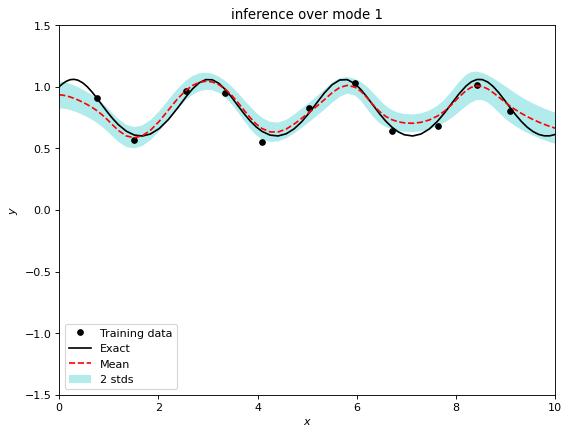

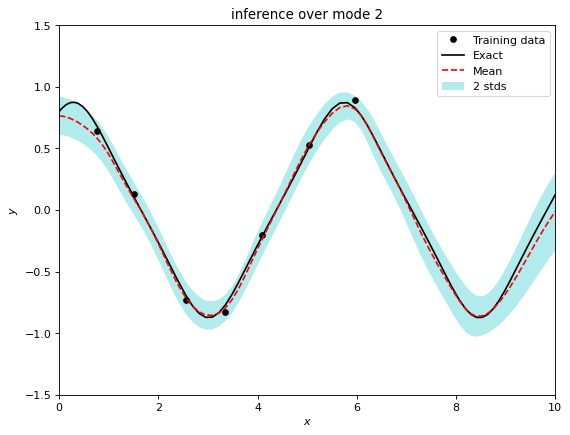

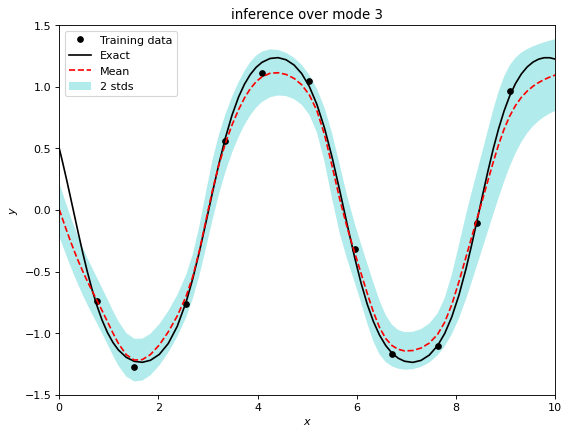

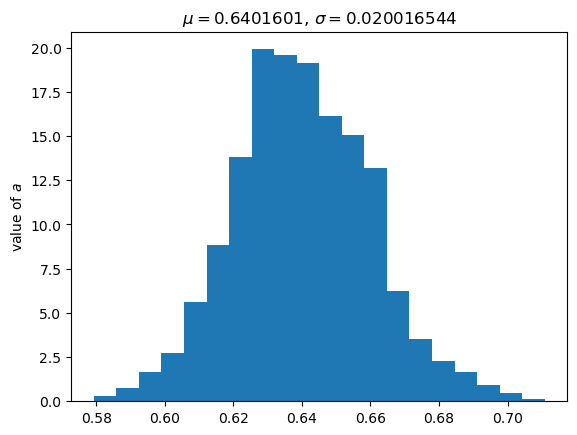

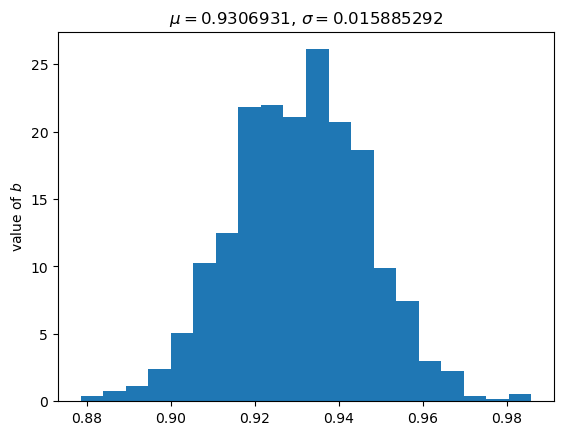

In [ ]:
# def load_data():
#     data = sio.loadmat("./Physics _Informed_NN/GaLA/KO_train.mat")
#     t_test, u_test = data["t_test"], data["u_test"]
#     t_u_train, u_train = data["t_u_train"], data["u_train"]
#     t_f_train, f_train = data["t_f_train"], data["f_train"]
#     noise = 0.05
#     return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test


# def ode_fn(t, u, a, b):
#     u1, u2, u3 = tf.split(u, 3, axis=-1)
#     u1_t = tf.gradients(u1, t)[0]
#     u2_t = tf.gradients(u2, t)[0]
#     u3_t = tf.gradients(u3, t)[0]

#     f1 = u1_t - a * u2 * u3
#     f2 = u2_t - b * u1 * u3
#     f3 = u3_t + (a + b) * u1 * u2
#     return tf.concat([f1, f2, f3], axis=-1)


# @neuq.utils.timer
# def MCD(t_u_train, u_train, t_f_train, f_train, noise, layers):
#     u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
#     t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
#     # build processes
#     process_u = neuq.process.Process(
#         surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
#         prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
#         posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
#     )
#     process_a = neuq.process.Process(
#         surrogate=neuq.surrogates.Identity(),
#         prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
#         posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
#     )
#     process_b = neuq.process.Process(
#         surrogate=neuq.surrogates.Identity(),
#         prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
#         posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
#     )
#     # build likelihoods
#     likelihood_u13 = neuq.likelihoods.Normal(
#         inputs=t_u_train,
#         targets=np.concatenate([u1_train, u3_train], axis=-1),
#         processes=[process_u],
#         out_dims=[[0, 2]],
#         sigma=noise,
#     )
#     likelihood_u2 = neuq.likelihoods.Normal(
#         inputs=t2_train,
#         targets=u2_train,
#         processes=[process_u],
#         out_dims=[[1]],
#         sigma=noise,
#     )
#     likelihood_f = neuq.likelihoods.Normal(
#         inputs=t_f_train,
#         targets=f_train,
#         processes=[process_u, process_a, process_b],
#         pde=ode_fn,
#         sigma=noise,
#     )
#     # build model
#     model = neuq.models.Model(
#         processes=[process_u, process_a, process_b],
#         likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
#     )
#     # assign and compile method
#     method = neuq.inferences.VI(
#         batch_size=64,
#         num_samples=1000,
#         num_iterations=20000,
#         optimizer=tf.train.AdamOptimizer(1e-3),
#     )
#     model.compile(method)
#     # obtain posterior samples
#     samples = model.run()

#     processes = [process_u, process_a, process_b]
#     return processes, samples, model


# def plots(u_pred, t_test, u_test, t_u_train, u_train):
#     u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
#     u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
#     u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
#     t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]  # training data

#     neuq.utils.plot1d(
#         t_u_train,
#         u1_train,
#         t_test,
#         u1_test,
#         u1_pred[..., 0],
#         title="inference over mode 1",
#         xlim=[0, 10],
#         ylim=[-1.5, 1.5],
#     )
#     neuq.utils.plot1d(
#         t2_train,
#         u2_train,
#         t_test,
#         u2_test,
#         u2_pred[..., 0],
#         title="inference over mode 2",
#         xlim=[0, 10],
#         ylim=[-1.5, 1.5],
#     )
#     neuq.utils.plot1d(
#         t_u_train,
#         u3_train,
#         t_test,
#         u3_test,
#         u3_pred[..., 0],
#         title="inference over mode 3",
#         xlim=[0, 10],
#         ylim=[-1.5, 1.5],
#     )


# ################## Load data and specify some hyperparameters ####################
# data = load_data()
# t_u_train, u_train, t_f_train, f_train, noise = data[:5]
# t_test, u_test = data[5:]
# layers = [1, 50, 50, 3]

# ####################### Build model and perform inference ########################
# # All models share the same general procedure:
# # Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# # Step 2: build prior and/or posterior using [variables]
# # Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# # Step 4: build likelihood, given noisy measurements, using [likelihoods]
# # Step 5: build model using [models]
# # Step 6: create an inference method and assign it to the model using [inferences]
# # Step 7: perform posterior sampling using [model.run]

# ############################### Choose framework #################################
# # processes, samples, model = Samplable(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )
# # processes, samples, model = Trainable(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )

# # Note: Variational tends to work better, visually, if noise for the likelihood is set
# # to be small, based on our experience. However, if the noise is known, we can't justify setting it to a small value,
# # just to produce better-looking results.
# # processes, samples, model = Variational(
# #     t_u_train, u_train, t_f_train, f_train, noise, layers
# # )
# processes, samples, model = MCD(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )

# ################################# Predictions ####################################
# u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

# ############################### Postprocessing ###################################
# plots(u_pred, t_test, u_test, t_u_train, u_train)
# neuq.utils.hist(a_pred.flatten(), name="value of $a$")
# neuq.utils.hist(b_pred.flatten(), name="value of $b$")